## Imports and helper functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from PIL import Image
import ipywidgets as widgets
from io import BytesIO
from IPython.display import display
import matplotlib as mpl
import imageio
import glob
import re
from tqdm import tqdm_notebook
import tqdm
import pickle


In [3]:
def tryint(s):
    try:
        return int(s)
    except:
        return s


def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [tryint(c) for c in re.split('([0-9]+)', s)]


def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
    
def arr2bytes(arr):
    """Display a 2- or 3-d numpy array as an image."""
    if arr.ndim == 2:
        format, cmap = 'png', mpl.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'jpg', None
    else:
        raise ValueError("Only 2- or 3-d arrays can be displayed as images.")
    # Don't let matplotlib autoscale the color range so we can control overall luminosity
    vmax = 255 if arr.dtype == 'uint8' else 1.0
    with BytesIO() as buffer:
        mpl.image.imsave(buffer, arr, format=format, cmap=cmap, vmin=0, vmax=vmax)
        out = buffer.getvalue()
    return out

# Defining functions to create the Environment

In [4]:
## Parameters for drawing the map

# The values correspond to the values we will plot the map with.

WALL_MAP_VALUE = 1
REWARD_MAP_VALUE = 2
EXIT_MAP_VALUE = 3


REWARD_SPARSITY = 0.1  

# The reward sparsity controls how many pixels will contain rewards. A reward sparsity of 0.1 means about 10% of the 
# pixels on average will contain rewards.                

In the report, we refer to a corridor with the term "room". The two terms are interchangeable.

In [5]:
def create_corridor(CORRIDOR_SHAPE, SEED = 42):
    """creates an array corresponding to a corridor of the level"""
    # instantiate corridor with rewards
    np.random.seed(SEED)
    corridor = np.random.choice([REWARD_MAP_VALUE, 0], size = CORRIDOR_SHAPE, p = [REWARD_SPARSITY, 1-REWARD_SPARSITY])

    # add walls
    SPACE = 5
    GAP = 2
    GAP_UP = -1
    GAP_DOWN = -2

    wall_x = SPACE
    orientation = GAP_UP

    while wall_x < CORRIDOR_SHAPE[0]:
        if orientation == GAP_UP: 
            corridor[wall_x, GAP:] = WALL_MAP_VALUE
            orientation = GAP_DOWN
        elif orientation == GAP_DOWN:
            corridor[wall_x, :-GAP] = WALL_MAP_VALUE
            orientation = GAP_UP
        wall_x += SPACE
        
    # place exit at the end of corridor and remove existing walls
    corridor[-1, :] = 0
    corridor[-1, CORRIDOR_SHAPE[1]//2] = EXIT_MAP_VALUE
    
        
    return corridor

def create_map(CORRIDOR_SHAPE, corridors):
    """creates a map from a list of corridors."""
    size = 2*CORRIDOR_SHAPE[0] + CORRIDOR_SHAPE[1] 
    center_xy = int((size - 1)/ 2)
    
    terrain = np.ones((size, size))
    
    # add right corridor
    if True:
        i = 0
        start_x  = int(center_xy + (CORRIDOR_SHAPE[1])/2) + 1
        end_x = int(start_x + CORRIDOR_SHAPE[0])

        start_y = int(center_xy - (CORRIDOR_SHAPE[1]-1)/2)
        end_y = int(start_y + CORRIDOR_SHAPE[1])

        terrain[start_x:end_x, start_y : end_y] = rotate(corridors[i], angle = 90*i)
    
    # add top corridor
    if True:
        i = 1
        start_x  = int(center_xy - (CORRIDOR_SHAPE[1]-1)/2)
        end_x = int(start_x + CORRIDOR_SHAPE[1])

        start_y = int(center_xy + (CORRIDOR_SHAPE[1]-1)/2) + 1
        end_y = int(start_y + CORRIDOR_SHAPE[0])

        terrain[start_x:end_x, start_y : end_y] = rotate(corridors[i], angle = 90*i)

    # add left corridor
    if True:
        i = 2
        start_x  = 0
        end_x = int(start_x + CORRIDOR_SHAPE[0])

        start_y = int(center_xy - (CORRIDOR_SHAPE[1]-1)/2) 
        end_y = int(start_y + CORRIDOR_SHAPE[1])

        terrain[start_x:end_x, start_y : end_y] = rotate(corridors[i], angle = 90*i)

    # add bottom corridor
    if True:
        i = 3
        start_x  = int(center_xy - (CORRIDOR_SHAPE[1]-1)/2)
        end_x = int(start_x + CORRIDOR_SHAPE[1])

        end_y = int(center_xy - (CORRIDOR_SHAPE[1]-1)/2)
        start_y = int(start_y - CORRIDOR_SHAPE[0])

        terrain[start_x:end_x, start_y : end_y] = rotate(corridors[i], angle = 90*i)
  
    # add Fork from starting position
    if True:
        terrain[center_xy , center_xy - CORRIDOR_SHAPE[1]//2: center_xy + CORRIDOR_SHAPE[1] //2 + 1] = 0
        terrain[center_xy - CORRIDOR_SHAPE[1]//2: center_xy + CORRIDOR_SHAPE[1] //2 + 1, center_xy] = 0
        
    return terrain
    
def create_env(CORRIDOR_SHAPE, SEEDS = [42, 43, 44, 45]):
    """creates both the corridors and the map."""
    corridors = [create_corridor(CORRIDOR_SHAPE, SEEDS[i]) for i in range(4)]
    env = create_map(CORRIDOR_SHAPE, corridors)
    return env
    

## Examples of maps we can generate

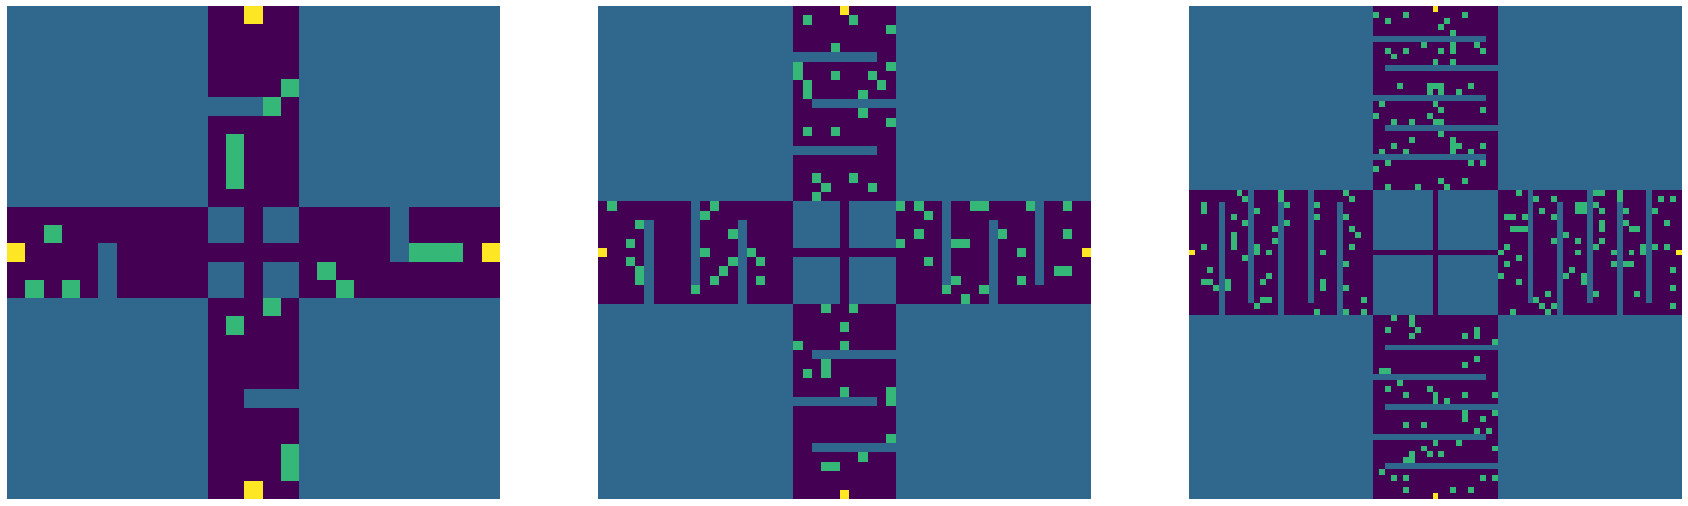

In [6]:
SEEDS = [42, 43, 44, 45]
CORRIDOR_SHAPE = (21, 11) # should be odd numbers for perfect symmetry

plt.subplot(1, 3, 1)

env = create_env((11, 5), SEEDS)
plt.imshow(rotate(env, angle= 90))
plt.axis('off')

plt.subplot(1, 3, 2)

env = create_env((21, 11), SEEDS)
plt.imshow(rotate(env, angle= 90))
plt.axis('off')

plt.subplot(1, 3, 3)

env = create_env((31, 21), SEEDS)
plt.imshow(rotate(env, angle= 90))
plt.axis('off')

fig = plt.gcf()
fig.set_size_inches(30,10)
plt.savefig("procedural_environments.jpg")

### Yellow = Exit,     Green = Rewards,  Blue = Walls (unexplorable coordinates)

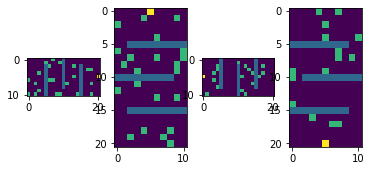

In [7]:
corridors = [create_corridor(CORRIDOR_SHAPE, SEEDS[i]) for i in range(4)]
for i, corridor in enumerate(corridors):
    plt.subplot(1, 4, i+1)
    plt.imshow(rotate(corridor.T, angle = 90*i))

## Define Agent class

In [8]:
class Agent():
    def __init__(self, CORRIDOR_SHAPE):
        # The agent's location is initialized in the middle of the map
        size = 2*CORRIDOR_SHAPE[0] + CORRIDOR_SHAPE[1] 
        center_xy = int((size - 1)/ 2)
        self.x = center_xy
        self.y = center_xy
    
    def action(self, choice):
        if choice == 0:
            # go left
            self.__move__(-1, 0)
        if choice == 1:
            # go up
            self.__move__(0, 1)
        if choice == 2:
            # go right:
            self.__move__(1, 0)
        if choice == 3:
            # go down
            self.__move__(0, -1)
        return
    
    def __move__(self, x, y):
        self.x += x
        self.y += y
        return
    
    def get_coords(self):
        return (self.x, self.y)

## Define Phase1 class for exploration

In [9]:
class Phase1():
    def __init__(self, CORRIDOR_SHAPE = (21, 11), SEEDS = [42, 43, 44, 45], alpha = 0.6):
        # HYPERPARAMETERS
        self.EXPLORE_ITER          = 200
        self.W1                    = 1    # weight of # of times chosen attribute
        self.W2                    = 1    # weight of # of times seen attribute
        self.W3                    = 1    # weight of # of times chosen since it has led to a new discovery attribute
        self.P1                    = 2    
        self.P2                    = 2    # powers of the attributes
        self.P3                    = 2
        self.E1                    = 1e-1   # constants for numerical stability. They avoid divison by 0 
        self.E2                    = 1e-1   # and make sure the probability of choosing a cell is never 0.
        self.WN_HORIZONTAL         = 10
        self.WN_VERTICAL           = 10     # weights of the neighbors used for computing
        self.WN_REWARD             = 100    # the Neighbor Score of a cell
        
        # Initialization
        self.env = create_env(CORRIDOR_SHAPE, SEEDS)
        self.MAX_SCORE = len(np.where(self.env == REWARD_MAP_VALUE)[0])
        self.agent = Agent(CORRIDOR_SHAPE = CORRIDOR_SHAPE)
        self.archive = {}               # contains the trajectory of actions leading to a cell
        self.cell_attributes = {}       # contains the three attributes of the cells
        self.cell_scores = {}           # contains the cell scores
        self.cell_states = {}           # contains the state of the environment and the position of the agent
        self.cell_cumulative_scores = {} # contains the cumulative score obtained at a given cell
        self.xys = {}
        
        # ucb
        self.num_trials = {}

        # Add initial cell in the middle of the map to the archive
        size = 2*CORRIDOR_SHAPE[0] + CORRIDOR_SHAPE[1] 
        center_xy = int((size - 1)/ 2)
        cell_key = "{},{}".format(center_xy, center_xy)
        
        self.archive[cell_key] = []
        self.cell_attributes[cell_key] = [0, 0, 0]
        self.cell_scores[cell_key] = 1
        self.cell_states[cell_key] = [self.env.copy(), self.agent.get_coords()]
        self.cell_cumulative_scores[cell_key] = 0
        self.xys[cell_key] = [(center_xy, center_xy)]
        
        # for ucb implementation
        self.time = 1
        self.alpha = alpha
        self.num_trials[cell_key] = 1
        
    def choose_cell(self):
        """Chooses a cell randomly from the archive thanks to cell scores."""
        # reset seed
        np.random.seed()
        
        keys = list(self.cell_scores.keys())
        scores = [self.cell_scores[key] for key in keys]
        trials = [self.num_trials[key] + 1 if key in self.num_trials else 1 for key in keys]

        ucb = np.array(scores) + self.alpha * (np.log(self.time) / np.array(trials)) ** 0.5
        #chosen_cell_key = np.random.choice(keys, size = 1, p = scores)[0]
        chosen_cell_key = keys[np.argmax(ucb)]
        chosen_cell_x = chosen_cell_key.split(',')[0]
        chosen_cell_y = chosen_cell_key.split(',')[1]
        
        # update number of times a cell has been chosen as a cell to explore from
        self.cell_attributes[chosen_cell_key][0] += 1
        if chosen_cell_key in self.num_trials:
            self.num_trials[chosen_cell_key] += 1
        else:
            self.num_trials[chosen_cell_key] = 1
        self.time += 1
        
        return (chosen_cell_x, chosen_cell_y)
    
    def store_cell(self, c, trajectory, cumulative_score, agent_xy):
        """Adds a cell c and the trajectory of actions that led to c to the archive."""
        cell_key = "{},{}".format(c[0], c[1])
        
        self.xys[cell_key] = agent_xy.copy()
        self.archive[cell_key] = trajectory.copy()
        self.cell_cumulative_scores[cell_key] = cumulative_score
        self.cell_states[cell_key] = [self.env.copy(), self.agent.get_coords()]
        
        try:
            # assert if cell was already in the archive. This is done to keep the attributes of the cell intact.
            len(self.cell_attributes[cell_key])
        except:
            # if the cell was not in the archive then we set its attributes to 0 and its score to 0
            self.cell_attributes[cell_key] = [0, 0, 0]
            self.cell_scores[cell_key] = 0
            
        return
        
    def should_store(self, c, trajectory, cumulative_score, agent_xy):
        """Assesses whether a cell c and the trajectory of actions that led to c shoud be stored in the archive."""
        cell_key = "{},{}".format(c[0], c[1])
        
        # if the cell was not in the archive it should be stored.
        if not cell_key in list(self.archive.keys()):
            return True
        
        # if the cell was already in the archive then it should be added if 
        #    i) the trajectory is shorter
        #   ii) the cumulative score is higher

        length_old_trajectory = len(self.xys[cell_key])
        length_new_trajectory = len(agent_xy)

        if length_new_trajectory < length_old_trajectory:
            if cumulative_score >= self.cell_cumulative_scores[cell_key]:
                return True

        if cumulative_score > self.cell_cumulative_scores[cell_key]:
            return True        
        return False
        
        
    def explore(self):
        """Launches exploration procedure."""
        # reset seed
        np.random.seed()
        
        self.agent = Agent(self.env.shape)
        starting_cell = self.choose_cell()
        starting_cell_key = "{},{}".format(starting_cell[0], starting_cell[1])
        
        self.agent.x = self.cell_states[starting_cell_key][1][0]
        self.agent.y = self.cell_states[starting_cell_key][1][1]
        self.env = self.cell_states[starting_cell_key][0].copy()
        cumulative_score = self.cell_cumulative_scores[starting_cell_key]
        trajectory = self.archive[starting_cell_key].copy()
        agent_xy = self.xys[starting_cell_key].copy()

        has_discovered = False
        
        oob_x = np.where(self.env[0] == 1)[0]
        oob_y = np.where(self.env[:,0] == 1)[0]

        oob = []
        for x in oob_x:
            for y in oob_y:
                oob.append((x, y))
        
        # Launch exploration
        for k in range(self.EXPLORE_ITER):
            # assess if oob
            if (self.agent.x, self.agent.y) in oob:
                print("OUT OF BOUNDS")
            
            
            # assess available actions
            possible_actions, _ = self.get_possible_actions(self.agent.x, self.agent.y)
            n = len(possible_actions)
            
            # choose an action randomly
            choice = np.random.choice(possible_actions, size = 1, p = [1/n] * n)[0]
            self.agent.action(choice)
                        
            # assess if agent has left the map
            if self.env[self.agent.x, self.agent.y] == EXIT_MAP_VALUE:
                break
            
            # update cell metadata
            reward = self.get_reward()
            if reward == 1:
                cumulative_score += reward
                self.env[self.agent.x, self.agent.y] = 0
    
            trajectory.append(choice)
            agent_xy.append(self.agent.get_coords())
            c = (self.agent.x, self.agent.y)
            cell_key ="{},{}".format(c[0], c[1])
            
            # store cell
            if self.should_store(c, trajectory, cumulative_score, agent_xy):
                self.store_cell(c, trajectory, cumulative_score, agent_xy)
                # reset number of times a cell has been chosen since it last produced the discovery of a new or better cell
                self.cell_attributes[starting_cell_key][2] = 0
                has_discovered = True
            
            # update number of times a cell was visited at any point during phase 1
            self.cell_attributes[cell_key][1] += 1
        ### END OF EXPLORATION
        
        # update number of times the starting cell has been chosen since it last produced the discovery of a new or better cell
        if has_discovered == False:
            self.cell_attributes[starting_cell_key][2] += 1
        
        self.compute_cell_scores()
        return
            
    def get_reward(self):
        """
        If the agent's location contains a reward, the reward is removed
        from the map and the value of the reward is returned.
        """
        x, y = self.agent.x, self.agent.y
        if self.env[x, y] == REWARD_MAP_VALUE:
            return 1
        else:
            return 0
            
    def get_possible_actions(self, x, y):
        """
        Assesses the possible actions available to the agent at location (x,y). For each action, 
        we assess if by taking this action the agent will still be in the bounds of the map
        and if it will not land in the wall.
        We also return the neighboring locations as they will be useful to compute the Neighbor Score
        of each cell.
        
        """        
        choices = []
        neighbors = []
        if x - 1 >= 0:
            if self.env[x-1, y] != WALL_MAP_VALUE:
                choices.append(0)
                neighbors.append((x-1, y))
        
        if y + 1 < self.env.shape[1]:
            if self.env[x, y+1] != WALL_MAP_VALUE:
                choices.append(1)
                neighbors.append((x, y+1))
        
        if x + 1 < self.env.shape[0]:
            if self.env[x+1, y] != WALL_MAP_VALUE:
                choices.append(2)
                neighbors.append((x+1, y))
        
        if y - 1 >= 0:
            if self.env[x, y-1] != WALL_MAP_VALUE:
                choices.append(3)
                neighbors.append((x, y-1))
                
        return choices, neighbors
    
    def cell_count_score(self, c):
        """Computes the Count Score of a given cell."""
        cell_key = "{},{}".format(c[0], c[1])
        attribute_values = np.array(self.cell_attributes[cell_key])
        attribute_weights = np.array([self.W1, self.W2, self.W3])
        attribute_powers = np.array([self.P1, self.P2, self.P3])
        
        scores = attribute_weights * ((attribute_values + self.E1)**-attribute_powers)
        
        return scores.sum() + self.E2
        
    def cell_neighbor_score(self, c):
        """Computes the Neighbor Score of a given cell."""
        _, neighbors = self.get_possible_actions(*c)
        scores = np.zeros(4)
        
        for i,neighbor in enumerate(neighbors):
            try:
                neighbor_key = "{},{}".format(neighbor[0], neighbor[1])
                len(self.archive[neighbor_key])
            except:
                # if this neighbor is new add associated score
                if self.env[neighbor] == REWARD_MAP_VALUE:
                    scores[i] = self.WN_REWARD
                elif i == 0 or i == 2:
                    scores[i] = self.WN_HORIZONTAL
                else:
                    scores[i] = self.WN_VERTICAL
        return scores.sum()
    
    def compute_cell_scores(self):
        """Computes the scores of every cell in the archive."""
        cell_keys = list(self.archive.keys())
        cell_scores = np.zeros(len(cell_keys))
        
        for i,cell_key in enumerate(cell_keys):
            c = (int(cell_key.split(',')[0]), int(cell_key.split(',')[1]))
            cell_scores[i] = self.cell_count_score(c) + self.cell_neighbor_score(c) + 1
        
        # cell_scores = cell_scores / cell_scores.sum()
        for i, cell_key in enumerate(cell_keys):
            self.cell_scores[cell_key] = cell_scores[i]        
        
        return

### Some functions

In [31]:
def get_best_trajectory(phase1):
    """Returns a the (x,y) tuples of the trajectory that got the best score"""
    max_score = -1
    cell = next(iter(phase1.cell_cumulative_scores.keys()))
    for key, value in phase1.cell_cumulative_scores.items():
        if value >= max_score and len(phase1.xys[key]) < len(phase1.xys[cell]):
            cell = key
        elif value > max_score:
            max_score = value
            cell = key

    path = phase1.xys[cell]
    real_trajectory_x = []
    real_trajectory_y = []

    for xy in path:
        real_trajectory_x.append(xy[0])
        real_trajectory_y.append(xy[1])

    real_trajectory_x = tuple(real_trajectory_x)
    real_trajectory_y = tuple(real_trajectory_y)

    real_trajectory = tuple([real_trajectory_x, real_trajectory_y])
    return real_trajectory

def get_best_trajectory_matrix(phase1):
    "returns the best trajectory plotted on the map"
    max_score = -1
    cell = next(iter(phase1.cell_cumulative_scores.keys()))
    for key, value in phase1.cell_cumulative_scores.items():
        if value >= max_score and len(phase1.xys[key]) < len(phase1.xys[cell]):
            cell = key
        elif value > max_score:
            max_score = value
            cell = key

    path = phase1.xys[cell]
    real_trajectory_x = []
    real_trajectory_y = []

    for xy in path:
        real_trajectory_x.append(xy[0])
        real_trajectory_y.append(xy[1])

    real_trajectory_x = tuple(real_trajectory_x)
    real_trajectory_y = tuple(real_trajectory_y)
    real_trajectory = tuple([real_trajectory_x, real_trajectory_y])

    env2 = phase1.cell_states[cell][0].copy()
    env2[real_trajectory] = EXIT_MAP_VALUE
    env2 = (env2 - env2.min()) / env2.max() * 255
    return env2

def get_neighbor_score_matrix(phase1):
    "returns the neighbor scores of the cells plotted against the map"
    score_matrix = np.zeros(phase1.env.shape)
    for key in phase1.cell_scores.keys():
        x = int(key.split(",")[0])
        y = int(key.split(",")[1])
        score_matrix[x, y] = phase1.cell_neighbor_score((x, y))

    min_score = score_matrix[score_matrix > 0].min()
    max_score = score_matrix.max()
    score_matrix = (score_matrix - min_score) / max_score

    return score_matrix

def get_score_matrix(phase1):
    "returns the cell scores plotted against the map"
    score_matrix = np.zeros(phase1.env.shape)

    for key, value in phase1.cell_scores.items():
        x = int(key.split(",")[0])
        y = int(key.split(",")[1])
        score_matrix[x, y] = value

    min_score = score_matrix[score_matrix > 0].min()
    max_score = score_matrix.max()
    # print(min_score, max_score)
    score_matrix = (score_matrix - min_score) / max_score * 255
    return score_matrix

def save_score_matrix(phase1, i):
    score_matrix = get_score_matrix(phase1)
    score_matrix = np.array(Image.fromarray(score_matrix).resize((512, 512)))
    path = "./score_results/score_matrix/score_matrix_" + str(i) + ".jpg"
    plt.imsave(path, score_matrix, cmap='gray')
    return path

def save_neighbor_score_matrix(phase1, i):
    score_matrix = get_neighbor_score_matrix(phase1)
    score_matrix = np.array(Image.fromarray(score_matrix).resize((512, 512)))
    path = "./score_results/neigh_score_matrix/score_matrix_" + str(i) + ".jpg"
    plt.imsave(path, score_matrix, cmap='gray')
    return path

def save_trajectory(phase1, i):
    trajectory = get_best_trajectory(phase1)
    env = phase1.env.copy()
    env[trajectory] = EXIT_MAP_VALUE
    env = np.array(Image.fromarray(env).resize((512, 512)))
    plt.imsave("./score_results/trajectory/trajectory_" + str(i) + ".jpg",
               env, cmap='gray')

def save_score_history(avg_score, variance, alpha, test_name="ucb_test"):
    x = [i+1 for i in range(len(avg_score))]
    plt.clf()
    plt.plot(x, avg_score, color='#1B2ACC')
    plt.fill_between(x, avg_score - variance, avg_score + variance, alpha = 0.4, facecolor='#089FFF')
    plt.title("Trajectory Max Score Versus Time")
    plt.xlabel("Trajectory number")
    plt.ylabel("Average score with variance")
    plt.savefig("./score_results/score_history_graphs/"+ test_name + "/score_history_" + str(alpha) + ".jpg")

c:\Users\joe\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(2, 10) (10,) (10,)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(2, 10) (10,) (10,)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(2, 10) (10,) (10,)


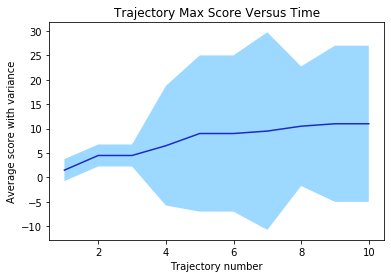

In [32]:
CORRIDOR_SHAPE = (21, 11) ## needs to be odd
N_TRIALS = 2
N_STEPS = 10
SAVE_EVERY = 10
REFRESH_EVERY = 10

for alpha_val in [0.01, 0.1, 0.5]:
    scores = [] 
    for trial_num in range(N_TRIALS):

        phase1 = Phase1(CORRIDOR_SHAPE, alpha = alpha_val)
        # The cell scores and the best trajectory found are saved during the run. The results are found in the folders
        # "score_matrix" and "trajectory"

        # Widgets for dynamically vizualising the state of phase 1
        neighscore_widget = widgets.Image(
            value=arr2bytes(np.array(Image.fromarray(get_neighbor_score_matrix(phase1)).resize((512,512)))),
            format='jpg',
            width=256,
            height=256,
        )

        trajectory_widget = widgets.Image(
            value=arr2bytes(np.array(Image.fromarray(get_best_trajectory_matrix(phase1)).resize((512,512)))),
            format='jpg',
            width=256,
            height=256,
        )


        # display(widgets.HBox([neighscore_widget, trajectory_widget]))

        ## Exploration loop
        best_scores = []
        for i in tqdm_notebook(range(N_STEPS)):
            if i % SAVE_EVERY == 0:
                save_path = save_score_matrix(phase1, i)
                save_trajectory(phase1, i)
                
            if i % REFRESH_EVERY == 0:
                neighscore_widget.value=arr2bytes((np.array(Image.fromarray(get_score_matrix(phase1)).resize((256,256)))))
                trajectory_widget.value=arr2bytes((np.array(Image.fromarray(get_best_trajectory_matrix(phase1)).resize((256,256)))))
            
            phase1.explore()
            
            best_score = max(phase1.cell_cumulative_scores.values())
            best_scores.append(best_score)
        best_scores = np.array(best_scores)
        scores.append(best_scores)
        # Finding the trajectory that solves the game
        max_score = -1
        cell = next(iter(phase1.cell_cumulative_scores.keys()))
        for key, value in phase1.cell_cumulative_scores.items():
            if value >= max_score and len(phase1.xys[key]) < len(phase1.xys[cell]):
                cell = key
            elif value > max_score:
                max_score = value
                cell = key

        path = phase1.xys[cell]
        real_trajectory_x = []
        real_trajectory_y = []

        for xy in path:
            real_trajectory_x.append(xy[0])
            real_trajectory_y.append(xy[1])
            
        real_trajectory_x = tuple(real_trajectory_x)
        real_trajectory_y = tuple(real_trajectory_y)

        real_trajectory = tuple([real_trajectory_x, real_trajectory_y])
    
    # create plot:
    scores = np.concatenate(scores, axis = 0).reshape(N_TRIALS,N_STEPS)
    mean = np.mean(scores, axis = 0)
    var = np.var(scores, axis = 0)
    print(scores.shape, mean.shape, var.shape)
    save_score_history(mean, var, alpha_val)

            

LEFT: Cell scores, RIGHT: Best Trajectory found

These are better seen in the saved images as the widgets do not easily support different shades of gray.

## Animate Exploration

In [19]:
### Make GIF of run
import imageio
import glob
import re
path = './'
filenames1 = [f for f in glob.glob(path + "score_matrix/*", recursive=True)]
filenames2 = [f for f in glob.glob(path + "trajectory/*", recursive=True)]

# drop every ten frames:
filenames1= [filenames1[i] for i in range(len(filenames1)) if i%10]
filenames2= [filenames2[i] for i in range(len(filenames2)) if i%10]
sort_nicely(filenames1)
sort_nicely(filenames2)

with imageio.get_writer('run2.gif', mode='I') as writer:
    for filename1, filename2 in zip(filenames1, filenames2):
        image1 = imageio.imread(filename1)
        image2 = imageio.imread(filename2)
        writer.append_data(np.concatenate([image1, image2], axis=1))

## Save Best Run

In [49]:
best_run = phase1.archive[cell]

In [50]:
with open("best_run.csv", "w") as file:
    for i in range(len(best_run)):
        string  = str(best_run[i]) + ",\n"
        file.write(string)

## Import Best Run

In [53]:
import pandas as pd
X = pd.read_csv("best_run.csv", header = None)
best_run1 = X.drop([1], axis = 1).to_numpy().flatten()

In [54]:
(best_run == best_run1).all()

True

## Animate Best Run

### Save frames of the run

In [71]:
SEEDS = [42, 43, 44, 45]
CORRIDOR_SHAPE = (21, 11) # should be odd numbers for perfect symmetry

# Find cell that solves the game
max_score = -1
cell = next(iter(phase1.cell_cumulative_scores.keys()))
for key, value in phase1.cell_cumulative_scores.items():
    if value >= max_score and len(phase1.xys[key]) < len(phase1.xys[cell]):
        cell = key
    elif value > max_score:
        max_score = value
        cell = key

agent_xy = phase1.xys[cell]
trajectory_tail = 60
alphas = np.linspace(0, 1, 61) ** 2

# Save images of the agent's location and state of the game
for i in tqdm_notebook(range(len(agent_xy))):
    env = create_env(CORRIDOR_SHAPE, SEEDS)
    tail = np.array(agent_xy[max(0, i-trajectory_tail):i+1])
    tail = (tuple(tail[:,0]), tuple(tail[:,1]))

    trajectory = np.array(agent_xy[:i+1])
    trajectory = (tuple(trajectory[:,0]), tuple(trajectory[:,1]))

    env[trajectory] = 0
    env[tail] = EXIT_MAP_VALUE * alphas[-min(trajectory_tail + 1, i+1):]
    env = np.array(Image.fromarray(env).resize((512, 512)))
    plt.imsave("./best_run/trajectory_{}.jpg".format(i), env, cmap = 'gray')
    


C:\Users\mjh24\AppData\Local\Temp/ipykernel_6536/3207157767.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(agent_xy))):


  0%|          | 0/5473 [00:00<?, ?it/s]

### Make GIF from frames 

In [72]:
path = './'
filenames = [f for f in glob.glob(path + "best_run/*", recursive=True)]
sort_nicely(filenames)


with imageio.get_writer('agent_run.gif', mode='I', fps = 60) as writer:
    for filename in tqdm_notebook(filenames):
        image = imageio.imread(filename)
        writer.append_data(image)

C:\Users\mjh24\AppData\Local\Temp/ipykernel_6536/2663405847.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for filename in tqdm_notebook(filenames):


  0%|          | 0/5473 [00:00<?, ?it/s]

C:\Users\mjh24\AppData\Local\Temp/ipykernel_6536/2663405847.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## Experiments

### Load experiments

In [12]:
filenames = [f for f in glob.glob("./experiments/**", recursive=True)]
sort_nicely(filenames)
_ = filenames.copy()
for file in _:
    if len(file) <= 20:
        filenames.remove(file)
filenames = list(dict.fromkeys(filenames))

In [ ]:
shapes = ["11_5", "21_11", "31_21"]

best_runs_score = {}

for shape in shapes:
    best_runs_score[shape] = []
    for filename in tqdm_notebook(filenames):
        if shape in filename:
            file = open(filename, 'rb')
            obj = pickle.load(file)
            best_runs_score[shape].append(obj[1])
            file.close()
            

In [ ]:
# Save scores to json
import json

with open('runs_scores.json', 'w') as fp:
    json.dump(best_runs_score, fp)

In [10]:
with open('./experiments/runs_scores.json') as handle:
    runs_scores = json.loads(handle.read())

In [13]:
shapes = ["11_5", "21_11", "31_21"]

# Normalize scores
for shape in shapes:
    m = max(max(runs_scores[shape]))
    for i,run in enumerate(runs_scores[shape]):
        for j,value in enumerate(run):
            runs_scores[shape][i][j] = value / m

### Plotting experiments

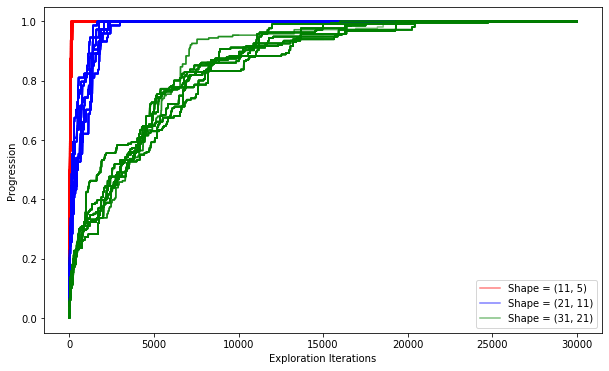

In [14]:
colors = ["red", "blue", "green"]
labels = ["Shape = (11, 5)", "Shape = (21, 11)", "Shape = (31, 21)"]
for i, shape in enumerate(shapes):
    for j,run in enumerate(runs_scores[shape]):
        if j == 0:
            plt.plot(np.arange(min(len(run), 30000)), run[:min(len(run), 30000)],
                     color = colors[i], alpha = 0.5, label = labels[i])
        else:
            plt.plot(np.arange(min(len(run), 30000)), run[:min(len(run), 30000)],
                     color = colors[i], alpha = 0.5)

plt.legend(loc = "lower right")
plt.xlabel("Exploration Iterations")
plt.ylabel("Progression")
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.savefig("experiments.jpg")

# Robustification via Imitation Learning

## Import Best Run

In [ ]:
import pandas as pd
X = pd.read_csv("best_run.csv", header = None)
best_run1 = X.drop([1], axis = 1).to_numpy().flatten()

## Define Environment Class

Action space : [left, up, right, down]

Observation space : [x_position, y_position, distance to target, score]

In [ ]:
import gym
from gym import spaces

In [ ]:
class Environment(gym.Env):
    def __init__(self, CORRIDOR_SHAPE = (21, 11), SEEDS = [42, 43, 44, 45],
                 env = None,
                 starting_position = (26, 26), starting_reward = 0, target_position = (22,19),
                 MAX_SCORE = 1):
        super(Environment, self).__init__()
        self.CORRIDOR_SHAPE = CORRIDOR_SHAPE
        self.SEEDS = SEEDS
        if env is None:
            self.env = create_env(self.CORRIDOR_SHAPE, self.SEEDS)
        else:
            self.env = env
        self.MAX_SCORE = MAX_SCORE
        self.size = 2*CORRIDOR_SHAPE[0] + CORRIDOR_SHAPE[1]
        self.MAX_DIST = np.sqrt(2*self.size**2)
        self.starting_position = np.array(starting_position)
        self.starting_reward = starting_reward
        self.target_position = np.array(target_position)
        self.starting_distance = np.linalg.norm(self.starting_position - target_position)
        
        self.REWARD_VALUE = 11
        self.STEP_PENALTY = 1
        
        #action space: [left, up, right, down]
        self.action_space = spaces.Discrete(4)
        
        # obsevation space: [x_position, y_position, distance to target, score]
        low = [0, 0, 0, 0]
        high = [self.size, self.size, self.MAX_DIST, self.MAX_SCORE]
        low = np.array(low)
        high = np.array(high)
        self.observation_space = spaces.Box(low, high)
        
    def reset(self):
        self.env = create_env(self.CORRIDOR_SHAPE, self.SEEDS)        
        self.current_state = np.array([self.starting_position[0], self.starting_position[1],
                                       self.starting_distance, self.starting_reward])
        return self._next_observation()
    
    def _next_observation(self):
        self.current_state = np.array(self.current_state)
        obs = self.current_state.copy()
        return obs
    
    def step(self, action):
        self._take_action(action)
        
        x_pos = int(self.current_state[0])
        y_pos = int(self.current_state[1])
        reward = int(self.env[x_pos, y_pos] == REWARD_MAP_VALUE) * self.REWARD_VALUE - self.STEP_PENALTY
        if reward >= 0:
            self.env[x_pos, y_pos] = 0
            self.current_state[3] += 1
        
        done = self.current_state[3] == self.MAX_SCORE
        
        obs = self._next_observation()
        
        return obs, reward, done, {}
    
    def _take_action(self, action):
        x_pos = int(self.current_state[0])
        y_pos = int(self.current_state[1])
        x = int(x_pos)
        y = int(y_pos)
        
        if action == 0:
            # go left
            if x_pos - 1 > 0:
                if self.env[x_pos - 1, y_pos] != WALL_MAP_VALUE: 
                    x = x_pos - 1
                
        if action == 1:
            # go up
            if y_pos + 1 < self.env.shape[1]:
                if self.env[x_pos, y_pos + 1] != WALL_MAP_VALUE:
                    y = y_pos + 1
                
        if action == 2:
            # go right
            if x_pos + 1 < self.env.shape[0]:
                if self.env[x_pos + 1, y_pos] != WALL_MAP_VALUE:
                    x = x_pos + 1
            
        if action == 3:
            # go down
            if y_pos - 1 > 0:
                if self.env[x_pos, y_pos - 1] != WALL_MAP_VALUE:
                    y = y_pos - 1
                
        xy = np.array([x, y])
                
        distance_to_target = np.linalg.norm(xy - self.target_position)
        self.current_state = np.array([x, y, distance_to_target, self.current_state[3]])
        return
    
    def render(self):
        return

## Optimization Process (do not run / to be continued)

In [ ]:
from stable_baselines.common.policies import MlpLstmPolicy
from stable_baselines.common import make_vec_env
from stable_baselines import PPO2
import tensorflow as tf

In [ ]:
def make_demonstration(action_trajectory):
    """Creates the demonstration sequence from a sequence of actions
       as required in the paper "Learning Montezuma’s Revenge from a Single Demonstration" """
    env = Environment()
    env.reset()
    demonstration = []
    actions = []
    game = create_env((21, 11))
    env_states = []
    agent_xy = [(26, 26)]

    for action in action_trajectory:    
        if(len(np.where(game == REWARD_MAP_VALUE)[0] > 0)):
            state_t = env._next_observation()
            action_t = action
            state_t1, reward, done, _ = env.step(action)
            x,y = agent_xy[-1]
            if action == 0:
                # go left
                agent_xy.append((x-1,y))
            if action == 1:
                # go up
                agent_xy.append((x,y+1))
            if action == 2:
                # go right
                agent_xy.append((x+1,y))
            if action == 3:
                # go down
                agent_xy.append((x,y-1))
            if game[x,y] == REWARD_MAP_VALUE:      
                game[x,y] = 0
            env_states.append(game.copy())
            demonstration.append(tuple([state_t, action_t, reward, state_t1, done, game.copy()]))
    return demonstration

In [ ]:
demonstration = make_demonstration(best_run1)

In [ ]:
def Demo_Initialized_Rollout_Worker(demonstration, model, starting_point = -10,
                                    batch_size = 32, memory_length = 10, batch_rollout_length = 30):
    
    state_t, action_t, reward_t, state_t1, done_t, env_state = demonstration[starting_point]
    _, _, _, target_state, _, _ = demonstration[-1]
    
    MAX_SCORE = len(np.where(env_state == REWARD_MAP_VALUE)[0])
    
    env_kwargs = {"env": env_state,
                  "starting_position" : state_t1[0:2],
                  "starting_reward" : 0,
                  "target_position" : target_state[0:2],
                  "MAX_SCORE" : MAX_SCORE
                 }
    
    success_counter = 0
    batch = []
    for j in range(batch_size):
        model.set_env(make_vec_env(Environment, n_envs = 1, env_kwargs = env_kwargs))
        env = model.env
        env.reset()
        sample = []
        values = []
        m = False
        hidden_state = None
        time_counter = starting_point - memory_length
        for step in range(batch_rollout_length):
            if time_counter < starting_point:
                state_t, action_t, _, _, _, _ = demonstration[time_counter]
                env = model.get_env()
                state_t1, reward, done, _ = env.step([action_t])
                m = False

                action, hidden_state = model.predict(state_t.reshape(1, state_t.shape[0]), hidden_state)
            else:
                action_t, hidden_state = model.predict(sample[-1][0].reshape(1, state_t.shape[0]), hidden_state)
                state_t1, reward, done, _ = env.step(action_t)
                m = True

            sample.append([state_t, action_t, reward, state_t1, done, m])
            time_counter += 1
            if done:
                success_counter += 1
        batch.append(sample)
    return batch, success_counter
                        
                
    

In [ ]:
def Optimizer(demonstration, model,
              batch_size = 32, success_threshold = 0.5,
              starting_point_shift = 10):
    starting_point = -starting_point_shift
    batch, success_counter = Demo_Initialized_Rollout_Worker(demonstration, model, starting_point)
    batch = np.array(batch)
    
    
    return batch
    

In [ ]:
env = make_vec_env(Environment, n_envs=1)

model = PPO2(MlpLstmPolicy, env, verbose=1, nminibatches = 1)

In [ ]:
obs = np.zeros((30, 4))
for j,state in enumerate(batch[0, :, 0]):
    obs[j] = state
values = np.zeros(30)
masks = batch[0, :, 5]
neglocpacs = np.zeros(30)
for j,ob in enumerate(obs):
    actions, states = model.predict([ob])
    _, value, _, neglocpac = model.step(ob.reshape(1, 4), state = states, mask = [masks[j]])
    values[j] = value[0]
    neglocpacs[j] = neglocpac[0]
    
actions = np.zeros(30)
for j,action in enumerate(batch[0, :, 1]):
    try:
        actions[j] = action[0]
    except:
        actions[j] = action
        
returns = np.zeros(30)
for j,reward in enumerate(batch[0, :, 1]):
    try:
        returns[j] = reward[0]
    except:
        returns[j] = reward
_, states = model.predict([ob])

model._train_step(learning_rate = 1e-5, cliprange = 0.1,
                  obs = obs, returns = returns, masks = masks,
                  actions = actions, values = values, update = 0, states= states,
                  neglogpacs = neglocpacs, writer = None)